In [7]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [8]:
# 读取两张图像
img1 = cv2.imread('image1.jpg')
img2 = cv2.imread('image2.jpg')

In [9]:
# 检测特征点和特征描述符
def detect_sift_features(image):
    sift = cv2.SIFT_create()
    (kps,des) = sift.detectAndCompute(image, None)
    return (kps,des)

In [10]:
# 匹配特征点
def match_features(kps1, des1, kps2, des2):
    # Brute Force匹配
    #matcher = cv2.BFMatcher()
    #matches = matcher.knnMatch(des1, des2, k=2)
    
    # FLANN匹配
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    matcher = cv2.FlannBasedMatcher(index_params, search_params)
    matches = matcher.knnMatch(des1, des2, k=2)

    # 筛选好的匹配点
    good_matches = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good_matches.append(m)

    # 提取坐标
    src_pts = np.float32([kps1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kps2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

    return src_pts, dst_pts, good_matches

In [11]:
# 转换为灰度图
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# 找到关键点和描述符
keypoints1, descriptors1 = detect_sift_features(gray1)
keypoints2, descriptors2 = detect_sift_features(gray2)

# 关键点匹配
src_pts, dst_pts, good_matches = match_features(keypoints1, descriptors1, keypoints2, descriptors2)

# 使用RANSAC算法计算单应性矩阵
H, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

print("单应性矩阵:\n", H)


单应性矩阵:
 [[ 1.25255591e+00  1.20448524e-01 -1.23436131e+02]
 [ 1.32572952e-01  1.22902782e+00 -5.31166731e+02]
 [ 8.92189475e-05  6.95054649e-06  1.00000000e+00]]


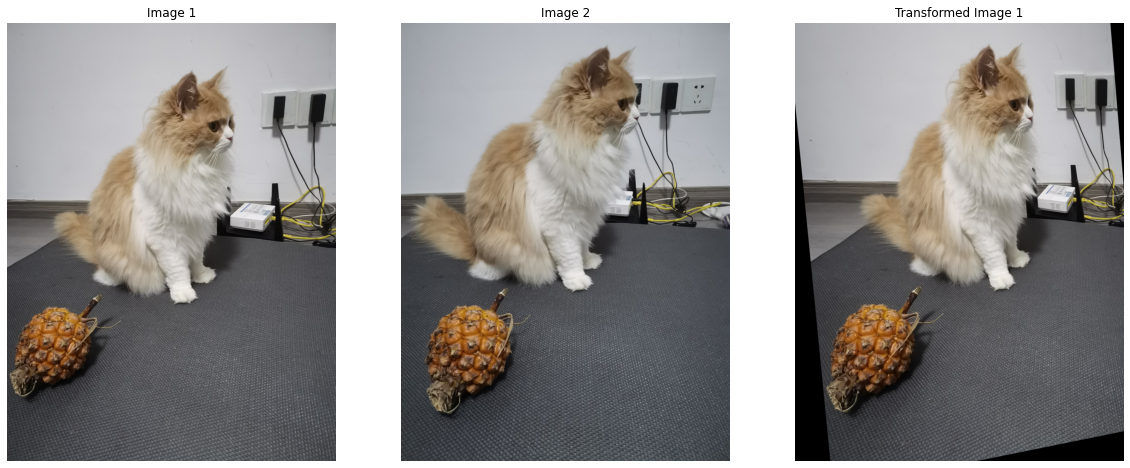

In [12]:
# 应用单应性变换
height, width, channels = img2.shape
img1_transformed = cv2.warpPerspective(img1, H, (width, height))

# 显示结果
plt.figure(figsize=(20, 10))

plt.subplot(1, 3, 1)
plt.title('Image 1')
plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Image 2')
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Transformed Image 1')
plt.imshow(cv2.cvtColor(img1_transformed, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.show()